In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam, SGD
import math, time, cv2, itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv').values

In [4]:
y = pd.get_dummies(train_data.label).values
X = train_data.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state = 0)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state = 0)
print(type(X_tr), type(y_tr), type(X_val), type(y_val), type(X_test), type(y_test))
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

/opt/anaconda/envs/subaru/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(30240, 784) (30240, 10) (7560, 784) (7560, 10) (4200, 784) (4200, 10)


In [5]:
def next_batch(step, batch_size, data, labels):
    return data[step*batch_size:(step + 1)*batch_size], labels[step*batch_size:(step + 1)*batch_size]

 ## Simple linear model

In [6]:
x_input = tf.placeholder(tf.float32, shape=[None, 784])
y_label = tf.placeholder(tf.float32, shape=[None, 10])

#W = tf.Variable(tf.zeros([784, 10]))
#b = tf.Variable(tf.zeros([10]))

W = tf.Variable(tf.truncated_normal([784, 10], stddev=0.1))
b = tf.Variable(tf.constant(0.1, shape=[10]))

y_pred = tf.matmul(x_input, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [7]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Epoch: 0 - Accuracy: 0.874339
Epoch: 1 - Accuracy: 0.878042
Epoch: 2 - Accuracy: 0.897354
Epoch: 3 - Accuracy: 0.880291
Epoch: 4 - Accuracy: 0.875132
Epoch: 5 - Accuracy: 0.885582
Epoch: 6 - Accuracy: 0.851058
Epoch: 7 - Accuracy: 0.884788
Epoch: 8 - Accuracy: 0.878439
Epoch: 9 - Accuracy: 0.87328


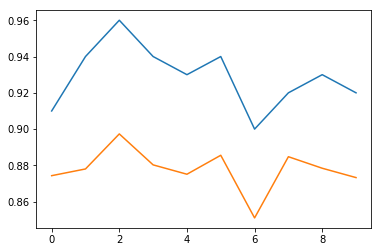

In [8]:
epochs = 10
batch_size = 100
steps = math.ceil(X_tr.shape[0] // batch_size)

train_accs = []
eval_accs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for step in range(steps):
            batch_X, batch_y = next_batch(step, batch_size, X_tr, y_tr)
            #if step % 50 == 0:
            #    train_accuracy = accuracy.eval(feed_dict={x_input: batch_X, y_label: batch_y})
            #    print('step %d, training accuracy %g' % (step, train_accuracy))
            train_step.run(feed_dict={x_input: batch_X, y_label: batch_y})
        train_accuracy = accuracy.eval(feed_dict={x_input: batch_X, y_label: batch_y})
        eval_accuracy = accuracy.eval(feed_dict={x_input: X_val, y_label: y_val})
        train_accs.append(train_accuracy)
        eval_accs.append(eval_accuracy)
        print('Epoch: %d - Accuracy: %g' % (epoch, eval_accuracy))

x = np.array(range(epochs))
plt.plot(x, train_accs)
plt.plot(x, eval_accs)
plt.show()

## TensorFlow Convolutional Network

In [9]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [10]:
# Input
x_input = tf.placeholder(tf.float32, shape=[None, 784])
y_label = tf.placeholder(tf.float32, shape=[None, 10])
x_image = tf.reshape(x_input, [-1, 28, 28, 1])

# Convoution layer 1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Convoution layer 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# FC layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Softmax layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Epoch 0, val accuracy 0.928307
Epoch 1, val accuracy 0.947884
Epoch 2, val accuracy 0.953439
Epoch 3, val accuracy 0.960185
Epoch 4, val accuracy 0.962434
Epoch 5, val accuracy 0.96336
Epoch 6, val accuracy 0.963889
Epoch 7, val accuracy 0.962037
Epoch 8, val accuracy 0.964153
Epoch 9, val accuracy 0.967328
Epoch 10, val accuracy 0.969048
Epoch 11, val accuracy 0.970635
Epoch 12, val accuracy 0.968651
Epoch 13, val accuracy 0.97209
Epoch 14, val accuracy 0.970899
Epoch 15, val accuracy 0.970635
Epoch 16, val accuracy 0.972222
Epoch 17, val accuracy 0.973545
Epoch 18, val accuracy 0.97619
Epoch 19, val accuracy 0.976984
Epoch 20, val accuracy 0.976587
Epoch 21, val accuracy 0.976455
Epoch 22, val accuracy 0.976587
Epoch 23, val accuracy 0.978042
Epoch 24, val accuracy 0.979101
Epoch 25, val accuracy 0.977381
Epoch 26, val accuracy 0.976455
Epoch 27, val accuracy 0.980159
Epoch 28, val accuracy 0.978175
Epoch 29, val accuracy 0.979233
test accuracy  0.9797619


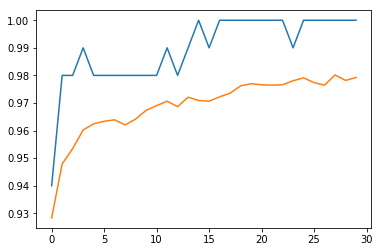

In [11]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epochs = 30
batch_size = 100
steps = math.ceil(X_tr.shape[0] // batch_size)

train_accs = []
eval_accs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for step in range(steps):
            batch_X, batch_y = next_batch(step, batch_size, X_tr, y_tr)
#             if step % 50 == 0:
#                 train_accuracy = accuracy.eval(feed_dict={x_input: batch_X, y_label: batch_y, keep_prob: 1.0})
#                 print('step %d, training accuracy %g' % (step, train_accuracy))
            train_step.run(feed_dict={x_input: batch_X, y_label: batch_y, keep_prob: 0.5})
        train_accuracy = accuracy.eval(feed_dict={x_input: batch_X, y_label: batch_y, keep_prob: 1.0})
        eval_accuracy = accuracy.eval(feed_dict={x_input: X_val, y_label: y_val, keep_prob: 1.0})
        print('Epoch %d, val accuracy %g' % (epoch, eval_accuracy))
        train_accs.append(train_accuracy)
        eval_accs.append(eval_accuracy)
    accuracy_l = accuracy.eval(feed_dict={x_input: X_test, y_label: y_test, keep_prob: 1.0})
    print('test accuracy ', accuracy_l)
        
x = np.array(range(epochs))
plt.plot(x, train_accs)
plt.plot(x, eval_accs)
plt.show()

## Keras model

In [12]:
model = Sequential()
model.add(Reshape((28, 28, 1), input_shape=(784,)))
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [14]:
epochs = 20
batch_size = 100
model.fit(X_tr, y_tr,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val)
         )

Train on 30240 samples, validate on 7560 samples
Epoch 1/20
30240/30240 [==============================] - 6s 200us/step - loss: 3.0079 - acc: 0.7674 - val_loss: 0.2799 - val_acc: 0.9561
Epoch 2/20
30240/30240 [==============================] - 5s 168us/step - loss: 0.2494 - acc: 0.9464 - val_loss: 0.0944 - val_acc: 0.9734
Epoch 3/20
30240/30240 [==============================] - 5s 170us/step - loss: 0.1160 - acc: 0.9682 - val_loss: 0.0715 - val_acc: 0.9799
Epoch 4/20
30240/30240 [==============================] - 5s 168us/step - loss: 0.0810 - acc: 0.9767 - val_loss: 0.0621 - val_acc: 0.9829
Epoch 5/20
30240/30240 [==============================] - 5s 170us/step - loss: 0.0609 - acc: 0.9809 - val_loss: 0.0579 - val_acc: 0.9841
Epoch 6/20
30240/30240 [==============================] - 5s 167us/step - loss: 0.0464 - acc: 0.9849 - val_loss: 0.0539 - val_acc: 0.9847
Epoch 7/20
30240/30240 [==============================] - 5s 175us/step - loss: 0.0354 - acc: 0.9880 - val_loss: 0.0590 - v

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.05045180900950852
Test accuracy: 0.9880952380952381
